# 1. Import Dependencies

In [ ]:
# Import tensorflow
import tensorflow as tf

# Import tensorflow datasets for Flower Dataset
#import tensorflow_datasets as tfds
# Import matplotlib for Visualising Data
from matplotlib import pyplot as plt
# Import numpy for Manipulating Data
import numpy as np
# Import OS for file handling
import os

# 2. Visualise and Build Dataset

### 2.1 Define Function to Retrieve Data

In [20]:
def get_data():
    # Define the path to the folder containing your images
    folder_path = 'dataset'

    # Get a list of all files in the directory and sort them numerically
    image_files = sorted([f for f in os.listdir(folder_path)])

    # Function to load and preprocess an image
    def load_image(image_path):
        # Load the raw data from the file as a string
        img = tf.io.read_file(image_path)
        # Decode it into an image tensor
        img = tf.image.decode_png(img, channels=3)
        return img

    # Create lists to store images and labels
    images = []
    labels = []

    # Load images and create labels
    for index, filename in enumerate(image_files):
        image_path = os.path.join(folder_path, filename)
        img = load_image(image_path)
        images.append(img)
        labels.append(index + 1)  # Labels are 1-based indices

    # Convert lists to tensors
    images = tf.stack(images)
    labels = tf.convert_to_tensor(labels)

    # Create a tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    # Store the dataset in a variable called ds
    ds = dataset.map(lambda img, lbl: {'image': img, 'label': lbl})
    
    return ds

### 2.2 Define Functions to Visualise, and scale data

In [24]:
# Define a function to visualise Data
def visualise_dataset(dataiterator):
    fig, ax = plt.subplots(ncols=4, figsize=(20,20))
    # Loop four times and get images 
    for idx in range(4): 
        # Grab an image and label
        sample = dataiterator.next()
        # Plot the image using a specific subplot 
        ax[idx].imshow(np.squeeze(sample['image']))
        # Appending the image label as the plot title 
        ax[idx].title.set_text(sample['label'])

In [26]:
# Define a function to Visualise Generated Images
def visualise_generated_images(img):
    fig, ax = plt.subplots(ncols=4, figsize=(20,20))
    # Loop four times and get images 
    for idx, img in enumerate(img): 
        # Plot the image using a specific subplot 
        ax[idx].imshow(np.squeeze(img))
        # Appending the image label as the plot title 
        ax[idx].title.set_text(idx)

In [43]:
# Scale and return images only 
def scale_images(data): 
    image = data['image']
    image = tf.image.resize(image, [IMG_RES,IMG_RES])
    return image / 255

# Scale and return dataset
def scale_dataset(data): 
    data['image'] = tf.image.resize(data['image'], [IMG_RES,IMG_RES])
    #data['image'] = tf.image.rgb_to_grayscale( data['image'])
    data['image'] = data['image'] / 255
    return data

### 2.3 Define constants

In [22]:
# Set a global Scale to control the height and width of dataset images
IMG_RES = 28
# Define Starting Resolution for images
START_RES= int(IMG_RES/4)


### 2.4 Get and Visualise data

In [46]:
ds = get_data()

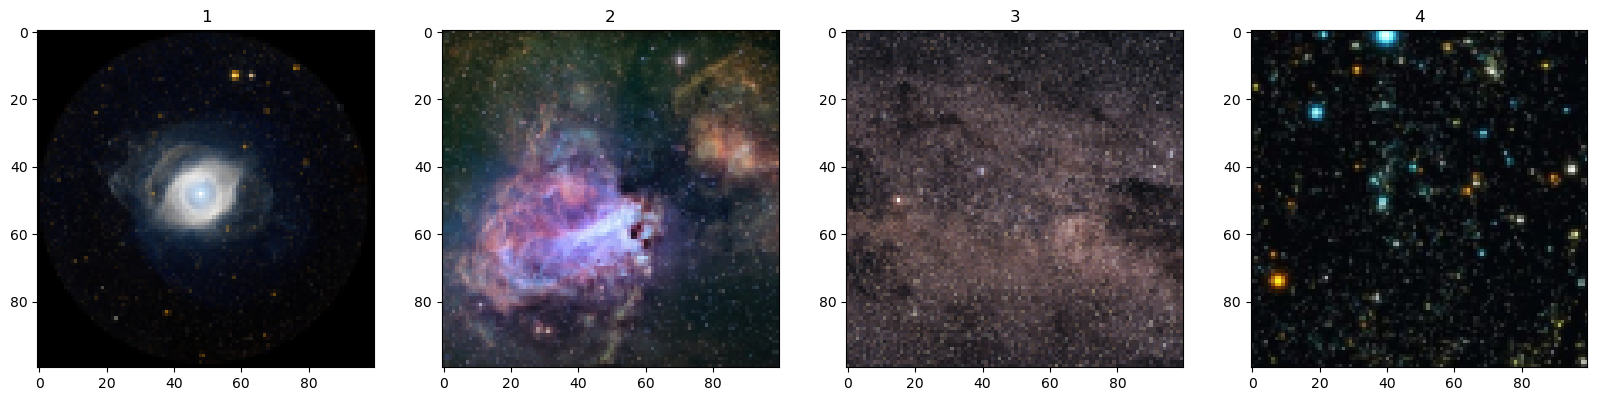

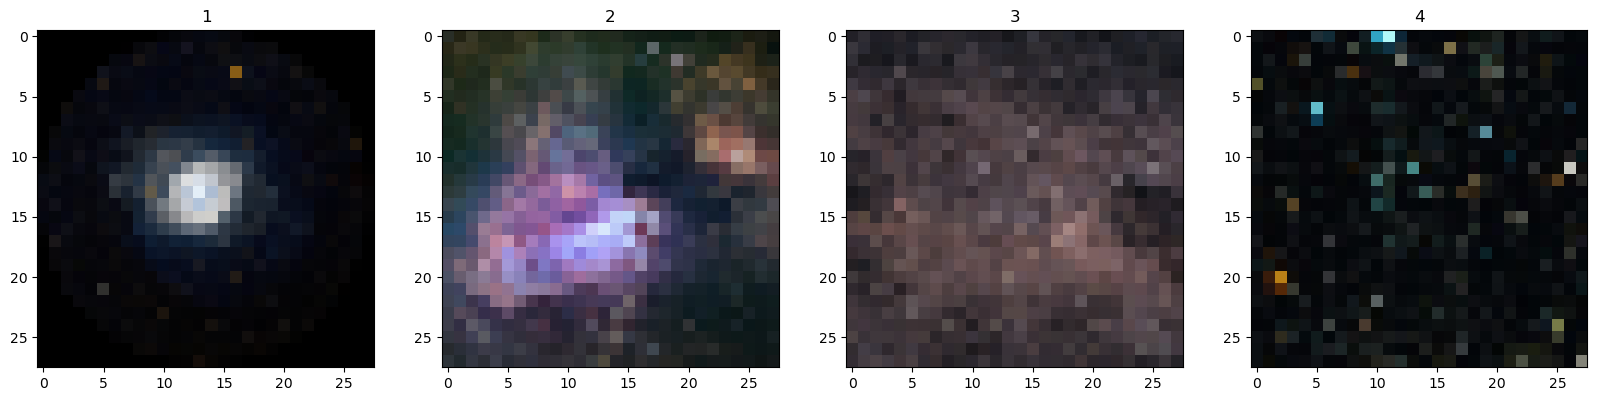

In [56]:
# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()
# Visualise Pre-scaled Dataset
visualise_dataset(dataiterator)

# Running the dataset through the scale_images preprocessing step
temp = ds.map(scale_dataset) 


# Setup connection aka iterator
dataiterator = temp.as_numpy_iterator()
# Check Images after Scaling
visualise_dataset(dataiterator)

### 2.5 PreProcess Data

In [62]:
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images) 
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)


# 3. Build Neural Network

### 3.1 Import Modelling Components

In [75]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, ReLU

### 3.2 Build Generator

In [78]:
def build_generator(): 
    model = Sequential()
    
    # Takes in random values and reshapes it to 25x25x128
    model.add(Dense(START_RES*START_RES*128, input_dim=128))
    model.add(ReLU())
    model.add(Reshape((START_RES,START_RES,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(ReLU())
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(ReLU())
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(ReLU())
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(ReLU())
    
    # Convolutional layer to get to Three channels
    model.add(Conv2D(3, 4, padding='same', activation='sigmoid'))
    
    return model

In [82]:
# Build a Generator
generator = build_generator()

In [84]:
generator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 6272)                │         809,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_7 (ReLU)                       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_8 (ReLU)                       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_9 (ReLU)                       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 3)           │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,159,235 (8.24 MB)

 Trainable params: 2,159,235 (8.24 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step


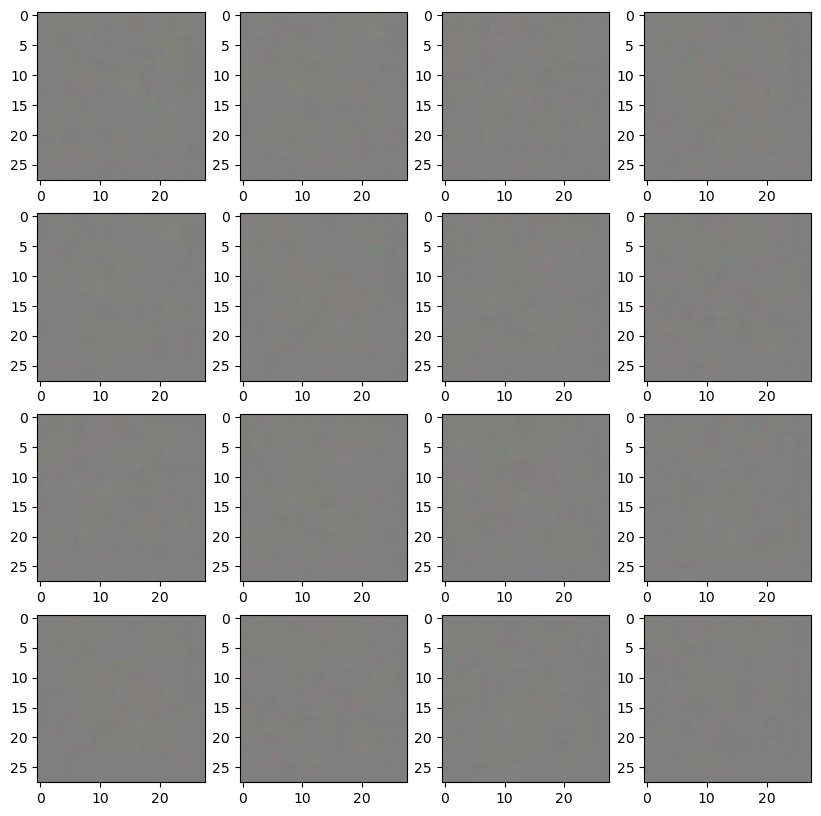

In [86]:
# Generate new Images
img = generator.predict(np.random.randn(16,128))
# Visualise the Generated Images
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(img[(r+1)*(c+1)-1])

### 3.3 Build Discriminator

In [88]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (IMG_RES,IMG_RES,3)))
    model.add(ReLU())

    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(ReLU())
  
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(ReLU())

    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(ReLU())

    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [93]:
discriminator = build_discriminator()

In [95]:
discriminator.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 24, 24, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_14 (ReLU)                      │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 20, 20, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_15 (ReLU)                      │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 16, 16, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_16 (ReLU)                      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 12, 12, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_17 (ReLU)                      │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │          36,865 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,114,945 (4.25 MB)

 Trainable params: 1,114,945 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

In [97]:
# Testing wether Discriminator Can classify Images as Real or fake
discriminator.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


array([[0.4948095 ],
       [0.49470076],
       [0.4946656 ],
       [0.49451464],
       [0.49466166],
       [0.49456576],
       [0.49481827],
       [0.49479955],
       [0.49461526],
       [0.49486107],
       [0.49470222],
       [0.49471077],
       [0.49479127],
       [0.49460027],
       [0.49476758],
       [0.49481022]], dtype=float32)

# 4. Construct Training Loop

### 4.1 Setup Losses and Optimizers

In [101]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam, SGD
# Binary cross entropy is going to be the loss for both 
from tensorflow.keras.losses import BinaryCrossentropy

In [103]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### 4.2 Build Subclassed Model

In [106]:
# Importing the base model class to subclass our training step 
from tensorflow.keras.models import Model

In [108]:
class GAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for generator and discrimnator
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backpropagation
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

    def set_discrimantor(self, discriminator):
        self.discriminator = discriminator

    def set_generator(self, generator):
        self.generator = generator
    

In [110]:
# Create instance of subclassed model
gan = GAN(generator, discriminator)

In [112]:
# Compile the model
gan.compile(g_opt, d_opt, g_loss, d_loss)

### 4.3 Build Callback

In [115]:
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [117]:
# Ensure the directory exists to save plots
images_dir = 'Images'
os.makedirs(images_dir, exist_ok=True)

class ModelMonitor(Callback):
    def __init__(self, num_img=1, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join(images_dir, f'generated_img_{epoch}_{i}.png'))

### 4.3 Train 

In [122]:
# Recommend 2000 epochs
hist = gan.fit(ds, epochs=500, callbacks=[ModelMonitor()])

Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 60s 5s/step - d_loss: 0.6912 - g_loss: 0.7282
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 56s 5s/step - d_loss: 0.6921 - g_loss: 0.6937
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - d_loss: 0.6567 - g_loss: 0.6928
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 62s 6s/step - d_loss: 0.6117 - g_loss: 0.6930
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 71s 6s/step - d_loss: 0.5593 - g_loss: 0.6934
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 72s 6s/step - d_loss: 0.5169 - g_loss: 0.6939
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 67s 6s/step - d_loss: 0.5057 - g_loss: 0.6943
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 69s 6s/step - d_loss: 0.5034 - g_loss: 0.6949
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 66s 6s/step - d_loss: 0.5062 - g_loss: 0.6955
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 68s 6s/step - d_loss: 0.5022 - g_loss: 0.6963
Epoch 11/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 66s 6s/step - d_loss: 0.5026 - g_loss: 0.6973
Epoch 12/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 68s 6s/step - d_loss: 0

KeyboardInterrupt: 

### 4.4 Review Performance

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# 5. Test Out the Generator

### 5.1 Generate Images

In [ ]:
#generator.load_weights('generator.keras')

In [119]:
imgs = generator.predict(tf.random.normal((16, 128)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


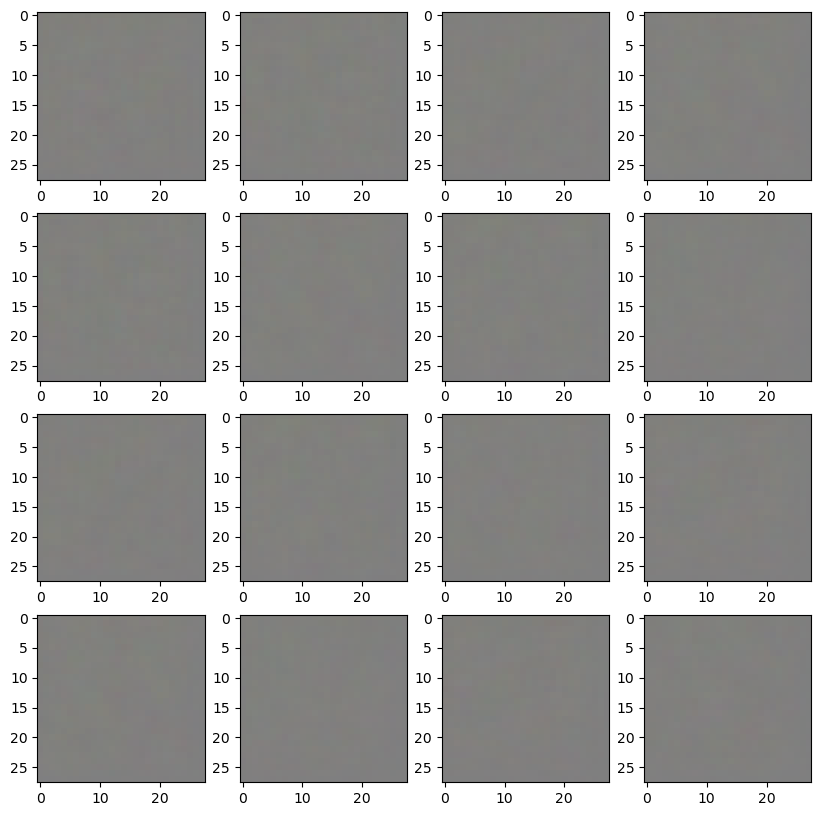

In [121]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

### 5.2 Save the Model

In [ ]:
#generator.save('generator.keras')
#discriminator.save('discriminator.keras')

# 6. Scale Images

In [ ]:
from tqdm import tqdm  # Import tqdm for progress bar

# Source and target directories
source_dir = 'Images\\R-1'
target_dir = 'Images\\R-1-scalled-1080'

# Ensure target directory exists
os.makedirs(target_dir, exist_ok=True)

# List all files in the source directory
file_list = os.listdir(source_dir)

# Initialize tqdm with total number of files
progress_bar = tqdm(total=len(file_list), desc='Processing Images', unit='image')

# Process each image file
for filename in file_list:
    if filename.endswith('.png') or filename.endswith('.jpg'):
        # Read image file
        image_path = os.path.join(source_dir, filename)
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)  # Automatically detects image format (PNG or JPEG)

        # Define target size for upscaling
        target_height = 1080
        target_width = 1080

        # Resize image using bilinear interpolation
        upscaled_image = tf.image.resize(image, [target_height, target_width], method=tf.image.ResizeMethod.BILINEAR)
        upscaled_image = tf.cast(upscaled_image, tf.uint8)

        # Save upscaled image to target directory with the same filename
        target_image_path = os.path.join(target_dir, filename)
        tf.io.write_file(target_image_path, tf.io.encode_png(upscaled_image))  # Adjust encode method as needed

        # Update tqdm progress bar
        progress_bar.update(1)

# Close tqdm progress bar
progress_bar.close()

print('Upscaling complete.')

# 7. Reload and Test

In [125]:
generator = tf.keras.models.load_model("generator.keras")
discriminator = tf.keras.models.load_model("discriminator.keras")

In [130]:
imgs = generator.predict(tf.random.normal((16, 128)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


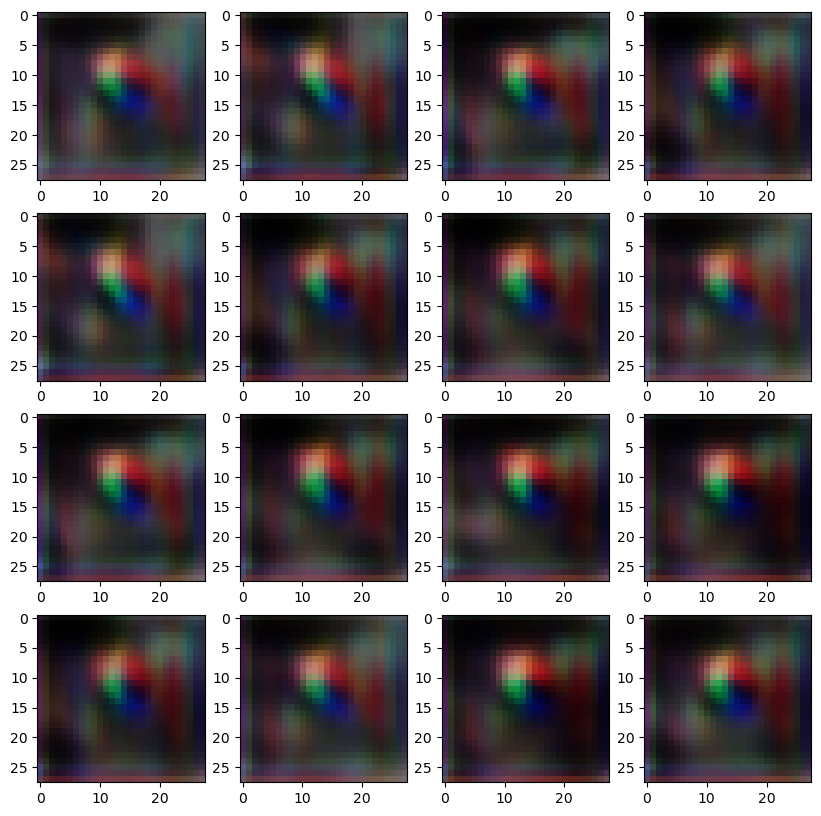

In [132]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])